In [1]:
import matplotlib.pyplot as plt
from astropy.io import ascii
import random
import numpy as np
import math
import copy
%matplotlib inline

In [227]:
class Kmean:
    def __init__(self,data,init='rand',C=3,verb=1):
        self.data=data
        self.verb=verb
        self.init=init
        self.C=C
        self.data['y']=-1
        self.colors=['r','g','b','cyan','magenta','purple','k']
        if self.C>len(self.colors):
            self.colors=self.colors*int(np.ceil(self.C/len(self.colors)))#clause for lots of classes
        self.Cov=np.cov(list(self.data.values())) #calcualting covarenince 
        if self.init=='rand':
            self.Random()
            self.mean()
        elif self.init=='forgy':
            self.Forgy()
        elif self.init=='K++':
            self.Kpp()
        else:
            print('Initialization type not recognized defaulting to random')
            self.init='rand'
            self.Random()
            self.mean()
        self.cluster()
    def Random(self): #Random init
            self.mu=[[-1,-1]]*self.C #allocating an empy array
            y=np.random.randint(0,self.C,len(self.data['y'])) #assigning ranomly labels
            test=1
            for i in range(self.C):
                test*=len(np.where(y==i)[0])#testing for empty group
            if test==0:
                while test==0:
                    y=np.random.randint(0,self.C,len(self.data['y']))
                    test=1
                    for i in range(self.C):
                        test*=len(np.where(y==i)[0])
            self.data['y']=y
    def Forgy(self):
        self.mu=[]
        sample=[]
        while len(np.unique(sample))!=self.C:
            sample=np.random.randint(0,len(self.data),self.C) #picking random samples to be the means
        for a in sample:
            muk=list(self.data['col1','col2'][a].values()) #apending the smaples into the list 
            self.mu.append(muk)       
    def Kpp(self):
        self.mu=[]
        self.mu.append(self.data['col1','col2'][np.random.randint(0,len(self.data))])# picking one random sample to be fit average
        while len(self.mu) < self.C:
            prob=np.zeros(len(self.data)) #creating empty array for proabilities
            for i in range(len(self.data)):
                t=[0]*len(self.mu) #creating empty array for distnace to each average
                for k in range(len(self.mu)):
                    t[k]=self.Dist2(self.data['col1','col2'][i],self.mu[k])**2 # claulating distnaces
                prob[i]=min(t) # picking smallest distnce for label
            prob/=sum(prob)#nomalizing poablities to sum to 1
            s=np.random.choice(np.arange(0,len(prob),1),p=prob) #picking ranom point with probliites of disnaces
            self.mu.append(self.data['col1','col2'][s])#appending new mean
    def Dist2(self,x,y):
        d=0
        if len(x)==len(y): #chicking for equal length
            for z in range(len(y)):
                d+=(x[z]-y[z])**2 #claulatnig each distnace step
        return np.sqrt(d)
    def cluster(self):
        for i in range(len(self.data)):
            t=[0]*self.C
            for k in range(self.C):
                t[k]=self.Dist2(self.data['col1','col2'][i],self.mu[k])**2 #calculating distances
            self.data[i]['y']=np.argmin(t) #labeling with closest mean
    def mean(self):
        for c in range(self.C):
            z=np.where(self.data['y']==c) #finding range for each label
            muk=[np.mean(self.data[z]['col1']),np.mean(self.data[z]['col2'])] #finding mean 
            self.mu[c]=muk 
    def Loss(self,norm=False):
        E=0
        for c in range(self.C):
            z=np.where(self.data['y']==c)
            for i in z[0]:
                E+=self.Dist2(self.data['col1','col2'][i],self.mu[c])#calculating error for each datapoint
        E/=len(self.data) #taking avearge
        if norm:
            return E/np.trace(self.Cov) #normalizing
        else:
            return(E)
    def plot(self,save=False):
        for i in range(len(self.data)):
            plt.scatter(self.data[i]['col1'],self.data[i]['col2'],color=self.colors[self.data[i]['y']]) #plotting points
        for c in range(self.C):
            plt.scatter(self.mu[c][0],self.mu[c][1],marker='*',color=self.colors[c],edgecolors='y') #plotting averages
        if save: #saving it i want to to save
            Name=input('File Name')
            plt.savefig('Images/'+Name,dpi=300)
        plt.show()
    def Sillouette(self,i):
        a=0
        b=0
        z=np.where(self.data[:]['y']==self.data[i]['y'])
        Cs=[0]*self.C
        Csl=[0]*self.C
        for j in range(len(self.data)):
                Cs[int(self.data[j]['y'])]+=self.Dist2(self.data[i]['col1','col2'],self.data[j]['col1','col2'])
                Csl[int(self.data[j]['y'])]+=1
        a=Cs[int(self.data[i]['y'])]
        a/=(len(z[0])-1) #normaling by samples
        B=[Cs[k]/Csl[k] for k in range(len(Cs)) if k!=(int(self.data[i]['y']))]
        if len(B)!=0:
            b=np.min(B) #normalizing
        else:
            b=a
        #print(a,b)
        #differnt cases for calualting silloute
        if a<b:
            return 1-(a/b) 
        elif a>b:
            return (b/a)-1
        else:
            return 0
    def AverageSillouette(self): 
        AS=0
        for i in range(len(self.data)):#itterating over all samples
            AS+=self.Sillouette(i)
        return AS/len(self.data) #averageing
    def run(self,itt=100):
        for i in range(itt):
            if self.verb>1: #printting update
                print('Itteration',i+1,'Log10(Loss): ',np.log10(self.Loss(norm=True)))
            self.oldmu = copy.deepcopy(self.mu)# copying mu
            self.mean() #taking new average
            self.cluster() #clustering to saaing label
            if np.array_equal(self.oldmu,self.mu):
                if self.verb>0:
                    print('Convergence Reached',i,' Itterations \nLog10(Loss):',np.log10(self.Loss(norm=True)))
                break
            if i ==itt-1:
                print('Max Itteration Reached')

In [228]:
three=ascii.read('three.csv') #readin data

Itteration 1 Log10(Loss):  -0.3120502175060421
Itteration 2 Log10(Loss):  -0.4450246881434601
Convergence Reached 1  Itterations 
Log10(Loss): -0.4450246881434601


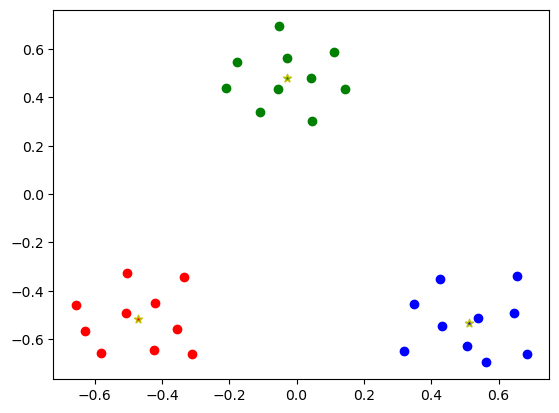

In [229]:
K=Kmean(three,init='K++',C=3,verb=2)#initlaizing
K.run() #running
K.plot(save=0) #plotting

In [230]:
Sillouttes=[]#emplty list for sillouttes

### C=1

In [231]:
Lossesi=[]# losses for this itteration
Sillouettesi=[] #sillouttes for these intterations
for i in range(10): #doing it 10 times 
    print('Itteration',i+1)
    K=Kmean(three,init='K++',C=1)# initialzing
    K.run() #running k menas
    Lossesi.append(np.log10(K.Loss(norm=True)))#apensing losses
    Sillouettesi.append(K.AverageSillouette()) #appedning average silloutte
Sillouttes.append(Sillouettesi[np.argmin(Lossesi)]) #appedning sillopute with lowest loss

Itteration 1
Convergence Reached 1  Itterations 
Log10(Loss): 0.16882476172207025
Itteration 2
Convergence Reached 1  Itterations 
Log10(Loss): 0.16882476172207025
Itteration 3
Convergence Reached 1  Itterations 
Log10(Loss): 0.16882476172207025
Itteration 4
Convergence Reached 1  Itterations 
Log10(Loss): 0.16882476172207025
Itteration 5
Convergence Reached 1  Itterations 
Log10(Loss): 0.16882476172207025
Itteration 6
Convergence Reached 1  Itterations 
Log10(Loss): 0.16882476172207025
Itteration 7
Convergence Reached 1  Itterations 
Log10(Loss): 0.16882476172207025
Itteration 8
Convergence Reached 1  Itterations 
Log10(Loss): 0.16882476172207025
Itteration 9
Convergence Reached 1  Itterations 
Log10(Loss): 0.16882476172207025
Itteration 10
Convergence Reached 1  Itterations 
Log10(Loss): 0.16882476172207025


### C=2

In [232]:
Lossesi=[]# losses for this itteration
Sillouettesi=[] #sillouttes for these intterations
for i in range(10): #doing it 10 times 
    print('Itteration',i+1)
    K=Kmean(three,init='K++',C=2)# initialzing
    K.run() #running k menas
    Lossesi.append(np.log10(K.Loss(norm=True)))#apensing losses
    Sillouettesi.append(K.AverageSillouette()) #appedning average silloutte
Sillouttes.append(Sillouettesi[np.argmin(Lossesi)]) #appedning sillopute with lowest loss

Itteration 1
Convergence Reached 3  Itterations 
Log10(Loss): -0.04440514438867738
Itteration 2
Convergence Reached 1  Itterations 
Log10(Loss): -0.04440514438867738
Itteration 3
Convergence Reached 1  Itterations 
Log10(Loss): -0.04440514438867738
Itteration 4
Convergence Reached 2  Itterations 
Log10(Loss): 0.014709408114682512
Itteration 5
Convergence Reached 2  Itterations 
Log10(Loss): -0.04440514438867738
Itteration 6
Convergence Reached 1  Itterations 
Log10(Loss): 0.024911521822258212
Itteration 7
Convergence Reached 1  Itterations 
Log10(Loss): -0.044405144388677494
Itteration 8
Convergence Reached 1  Itterations 
Log10(Loss): -0.04440514438867738
Itteration 9
Convergence Reached 1  Itterations 
Log10(Loss): -0.003862267066734318
Itteration 10
Convergence Reached 1  Itterations 
Log10(Loss): 0.014709408114682512


### C=3


In [233]:
Lossesi=[]# losses for this itteration
Sillouettesi=[] #sillouttes for these intterations
for i in range(10): #doing it 10 times 
    print('Itteration',i+1)
    K=Kmean(three,init='K++',C=3)# initialzing
    K.run() #running k menas
    Lossesi.append(np.log10(K.Loss(norm=True)))#apensing losses
    Sillouettesi.append(K.AverageSillouette()) #appedning average silloutte
Sillouttes.append(Sillouettesi[np.argmin(Lossesi)]) #appedning sillopute with lowest loss

Itteration 1
Convergence Reached 1  Itterations 
Log10(Loss): -0.4450246881434601
Itteration 2
Convergence Reached 1  Itterations 
Log10(Loss): -0.44502468814346
Itteration 3
Convergence Reached 1  Itterations 
Log10(Loss): -0.4450246881434601
Itteration 4
Convergence Reached 1  Itterations 
Log10(Loss): -0.4450246881434601
Itteration 5
Convergence Reached 2  Itterations 
Log10(Loss): -0.05323515026490681
Itteration 6
Convergence Reached 1  Itterations 
Log10(Loss): -0.4450246881434601
Itteration 7
Convergence Reached 1  Itterations 
Log10(Loss): -0.4450246881434601
Itteration 8
Convergence Reached 1  Itterations 
Log10(Loss): -0.4450246881434601
Itteration 9
Convergence Reached 1  Itterations 
Log10(Loss): -0.4450246881434601
Itteration 10
Convergence Reached 1  Itterations 
Log10(Loss): -0.4450246881434601


### C=4

In [234]:
Lossesi=[]# losses for this itteration
Sillouettesi=[] #sillouttes for these intterations
for i in range(10): #doing it 10 times 
    print('Itteration',i+1)
    K=Kmean(three,init='K++',C=4)# initialzing
    K.run() #running k menas
    Lossesi.append(np.log10(K.Loss(norm=True)))#apensing losses
    Sillouettesi.append(K.AverageSillouette()) #appedning average silloutte
Sillouttes.append(Sillouettesi[np.argmin(Lossesi)]) #appedning sillopute with lowest loss

Itteration 1
Convergence Reached 1  Itterations 
Log10(Loss): -0.4761808827968402
Itteration 2
Convergence Reached 1  Itterations 
Log10(Loss): -0.47580551097818424
Itteration 3
Convergence Reached 1  Itterations 
Log10(Loss): -0.47530743594080355
Itteration 4
Convergence Reached 1  Itterations 
Log10(Loss): -0.47801634741943316
Itteration 5
Convergence Reached 2  Itterations 
Log10(Loss): -0.48052228075336706
Itteration 6
Convergence Reached 1  Itterations 
Log10(Loss): -0.47521133675123167
Itteration 7
Convergence Reached 1  Itterations 
Log10(Loss): -0.4827736813936619
Itteration 8
Convergence Reached 1  Itterations 
Log10(Loss): -0.4675881589671708
Itteration 9
Convergence Reached 3  Itterations 
Log10(Loss): -0.4812606358594882
Itteration 10
Convergence Reached 2  Itterations 
Log10(Loss): -0.48202829020987387


### C=5

In [235]:
Lossesi=[]# losses for this itteration
Sillouettesi=[] #sillouttes for these intterations
for i in range(10): #doing it 10 times 
    print('Itteration',i+1)
    K=Kmean(three,init='K++',C=5)# initialzing
    K.run() #running k menas
    Lossesi.append(np.log10(K.Loss(norm=True)))#apensing losses
    Sillouettesi.append(K.AverageSillouette()) #appedning average silloutte
Sillouttes.append(Sillouettesi[np.argmin(Lossesi)]) #appedning sillopute with lowest loss

Itteration 1
Convergence Reached 2  Itterations 
Log10(Loss): -0.5104189565922992
Itteration 2
Convergence Reached 1  Itterations 
Log10(Loss): -0.5165524463652391
Itteration 3
Convergence Reached 1  Itterations 
Log10(Loss): -0.5115232385132632
Itteration 4
Convergence Reached 2  Itterations 
Log10(Loss): -0.5220467244049177
Itteration 5
Convergence Reached 2  Itterations 
Log10(Loss): -0.5148316947226534
Itteration 6
Convergence Reached 1  Itterations 
Log10(Loss): -0.5061924022448571
Itteration 7
Convergence Reached 1  Itterations 
Log10(Loss): -0.5174936864687926
Itteration 8
Convergence Reached 1  Itterations 
Log10(Loss): -0.5111047533415153
Itteration 9
Convergence Reached 1  Itterations 
Log10(Loss): -0.5055166858482177
Itteration 10
Convergence Reached 2  Itterations 
Log10(Loss): -0.49874191095366327


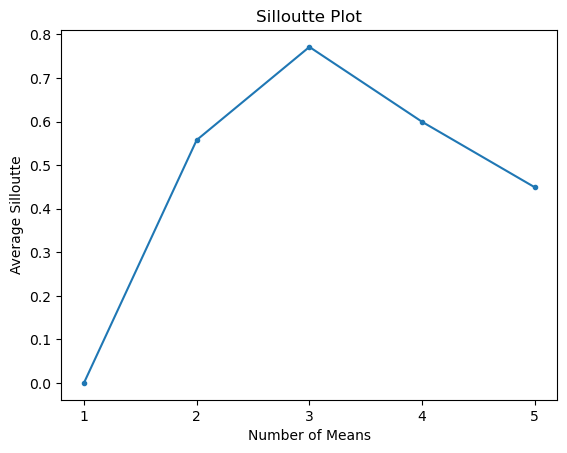

[0.0, 0.5575974178219295, 0.7713845060772166, 0.599394081982417, 0.44900423816692053]


In [236]:
#plotting average sillouttes
plt.plot([1,2,3,4,5],Sillouttes,marker='.')
plt.xticks([1,2,3,4,5])
plt.xlabel('Number of Means')
plt.ylabel('Average Silloutte')
plt.title('Silloutte Plot')
plt.savefig('Images/SillouttePlot.png',dpi=300)
plt.show()
print(Sillouttes)

In [237]:
atoll=ascii.read('atoll.csv') #reading in new dataset

Itteration 1
Convergence Reached 6  Itterations 
Log10(Loss): 0.08233017340176049


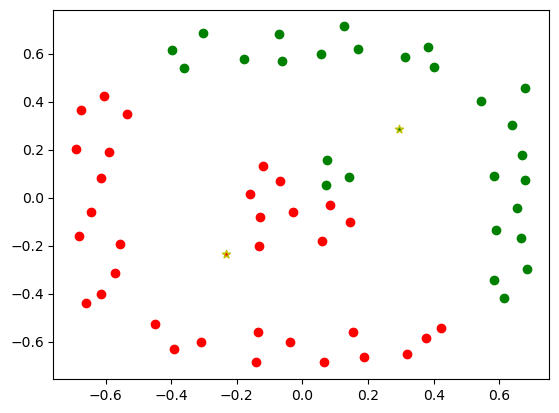

Itteration 2
Convergence Reached 2  Itterations 
Log10(Loss): 0.08482962788031433


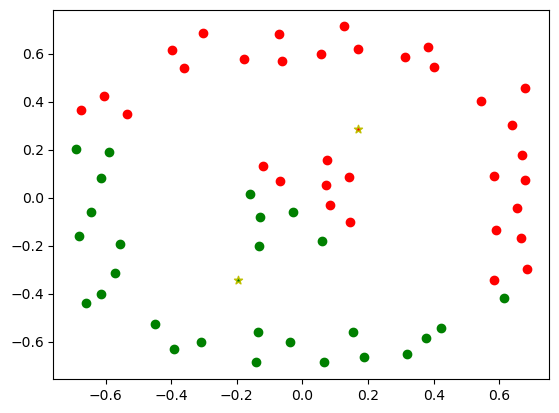

Itteration 3
Convergence Reached 2  Itterations 
Log10(Loss): 0.08268644619586546


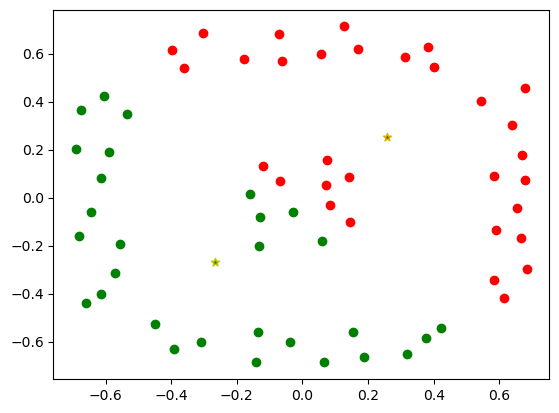

Itteration 4
Convergence Reached 1  Itterations 
Log10(Loss): 0.0827862693897903


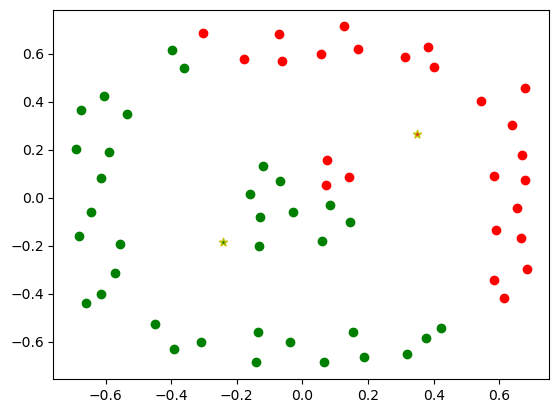

Itteration 5
Convergence Reached 3  Itterations 
Log10(Loss): 0.08233017340176066


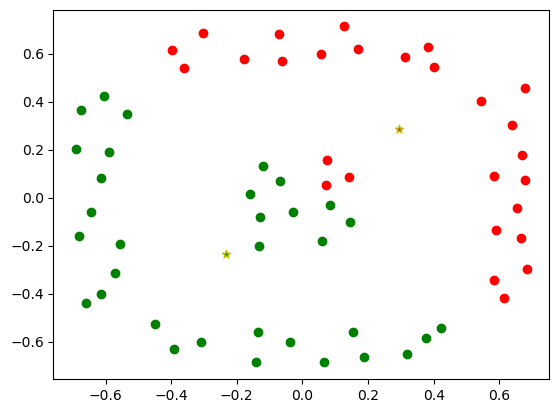

Itteration 6
Convergence Reached 1  Itterations 
Log10(Loss): 0.08368885266338598


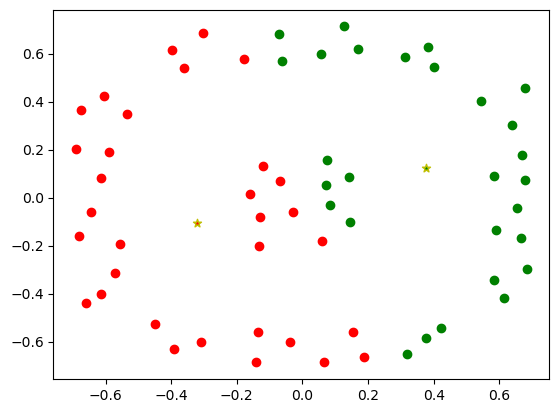

Itteration 7
Convergence Reached 5  Itterations 
Log10(Loss): 0.0827862693897903


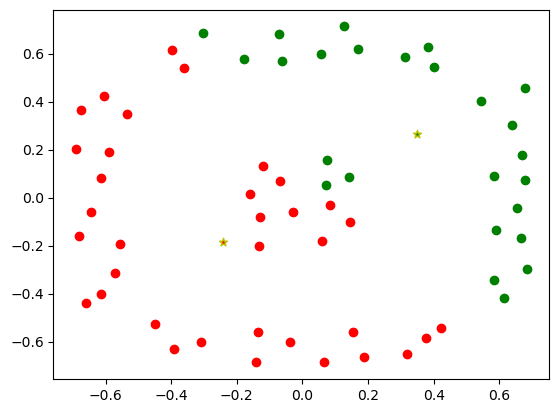

Itteration 8
Convergence Reached 1  Itterations 
Log10(Loss): 0.08374466471199116


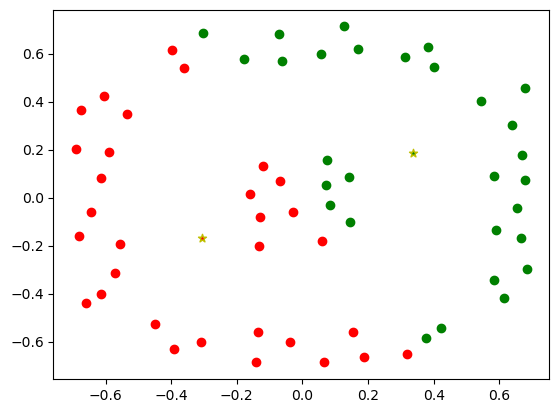

Itteration 9
Convergence Reached 5  Itterations 
Log10(Loss): 0.0847801505867826


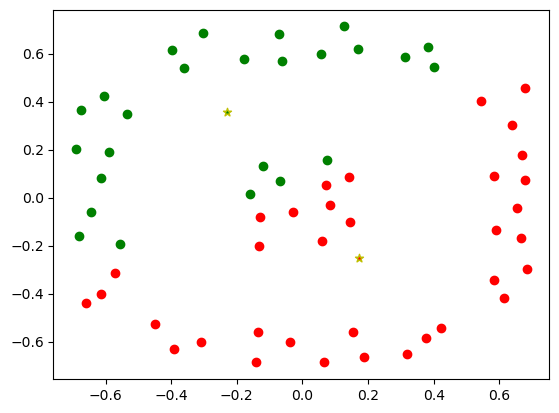

Itteration 10
Convergence Reached 5  Itterations 
Log10(Loss): 0.08442532022009569


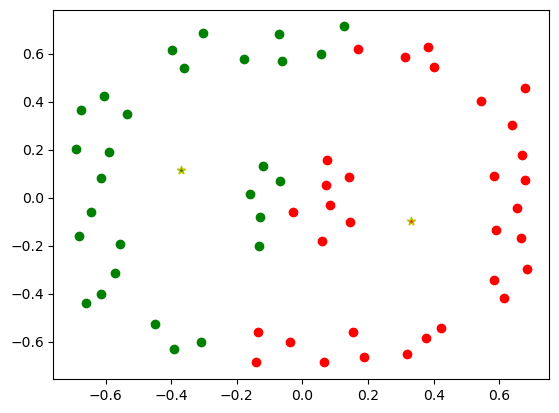

In [238]:
#running k-means with C=2 10 times
for i in range(10):
    print('Itteration',i+1)
    K2=Kmean(atoll,init='K++',C=2,verb=1)
    K2.run()
    K2.plot()

Itteration 1
Convergence Reached 3  Itterations 
Log10(Loss): -0.13585562433891277


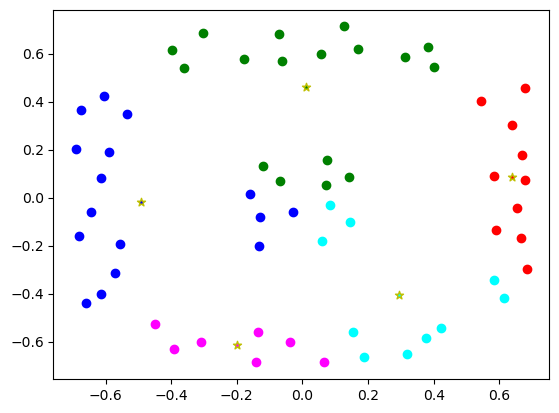

Itteration 2
Convergence Reached 2  Itterations 
Log10(Loss): -0.16128003029237103


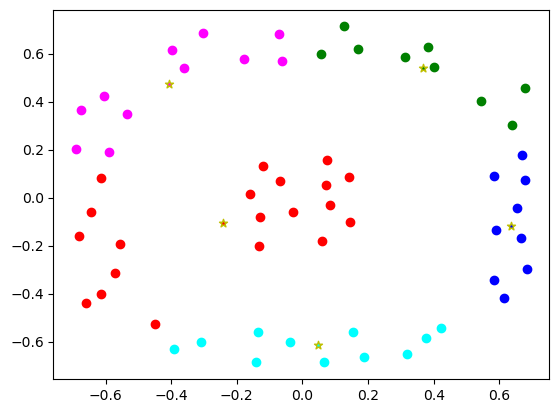

Itteration 3
Convergence Reached 3  Itterations 
Log10(Loss): -0.141098035455307


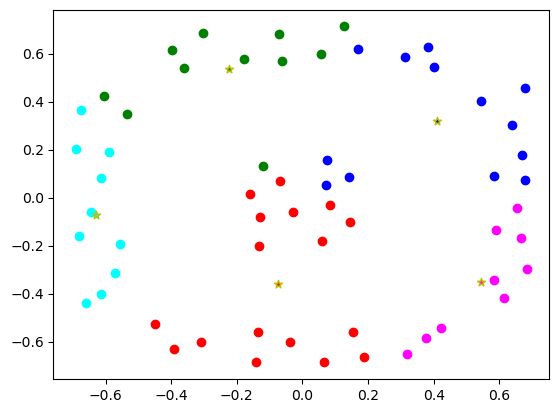

Itteration 4
Convergence Reached 3  Itterations 
Log10(Loss): -0.20269822997847461


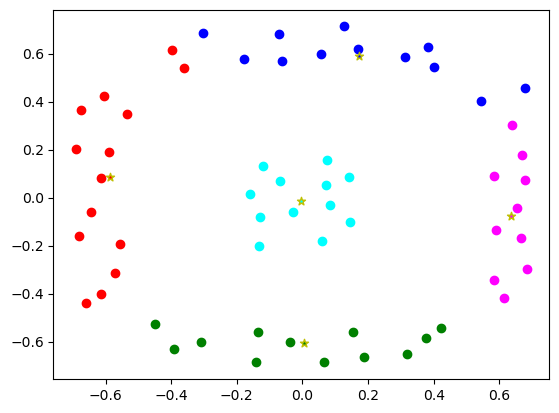

Itteration 5
Convergence Reached 5  Itterations 
Log10(Loss): -0.14337576295108878


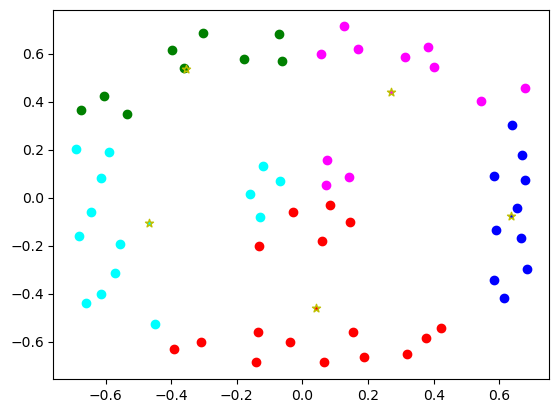

Itteration 6
Convergence Reached 3  Itterations 
Log10(Loss): -0.1383555081687376


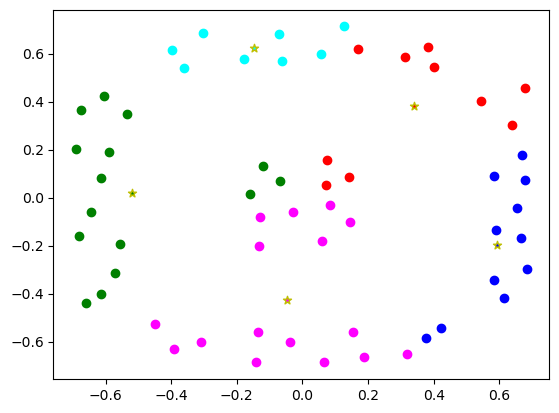

Itteration 7
Convergence Reached 4  Itterations 
Log10(Loss): -0.14083088991030523


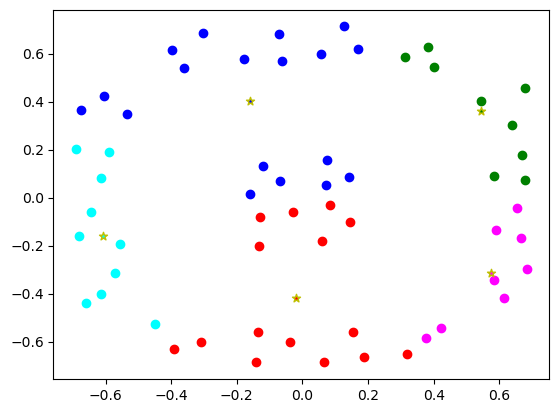

Itteration 8
Convergence Reached 6  Itterations 
Log10(Loss): -0.14478709438628443


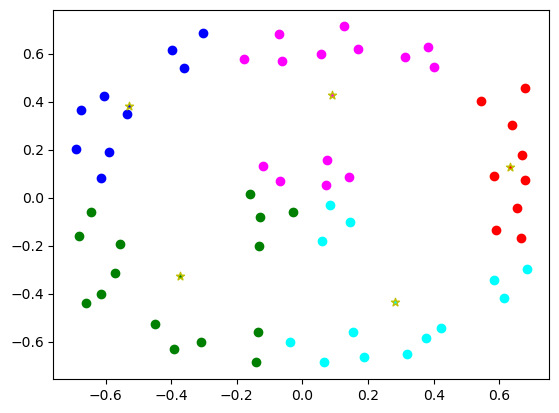

Itteration 9
Convergence Reached 3  Itterations 
Log10(Loss): -0.1344106190411504


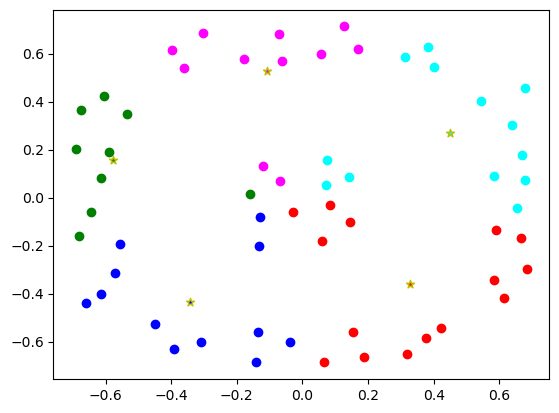

Itteration 10
Convergence Reached 3  Itterations 
Log10(Loss): -0.1903069652964721


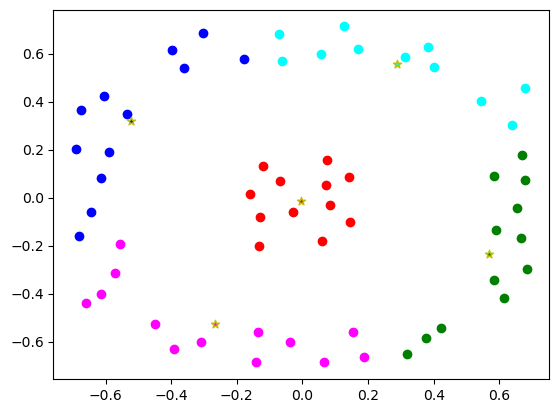

In [239]:
#running k-means with C=5 10 times
for i in range(10):
    print('Itteration',i+1)
    K2=Kmean(atoll,init='K++',C=5,verb=1)
    K2.run()
    K2.plot()